In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import pydeck as pdk

import wetterdienst
import matplotlib.pyplot as plt
import pathlib
import joblib
import geopandas as gpd
import contextily as ctx


In [3]:
data = pathlib.Path("data")
current = joblib.load((data / "current_cleaned.joblib"))
wave =  joblib.load((data / "wave_cleaned.joblib"))
wind =  joblib.load((data / "wind_cleaned.joblib"))
ais = joblib.load((data / "cleaned_ais_cargo_tanker_dataset.joblib"))

## Assoziierung der AIS und Wetterdaten über space-time join
#### min(ais_timestamp - weather_timestamp) & min(entfernung)-> mittels h3 index (ais_h3 == weather_h3)

Der Zeitjoin ist easy, aber wie beides? -> h3 Spatial Index als on key -> dadurch automatisch nächsten Punkt

In [4]:
import h3.api.numpy_int as h3
import h3.unstable.vect as vect_h3

from typing import Union

import functools

def to_h3(row, h3_level=6):
    @functools.lru_cache
    def calc_h3(latitude, longitude, level):
        return h3.geo_to_h3(latitude, longitude, level)
    return calc_h3(row.latitude,row.longitude,h3_level)


def vect_to_h3(df, h3_level):
    df[f"h3_res_{h3_level}"] = vect_h3.geo_to_h3(df.latitude,df.longitude,h3_level)
    return df


def calc_hex_res(
    df
) -> pd.DataFrame:
    resolutions = [4, 5, 6, 7, 8, 9]
    for res in resolutions:
        df = df.pipe(vect_to_h3, res)
    return df


c:\users\deeman\appdata\local\pypoetry\cache\virtualenvs\aisfeel-wcuqt8d_-py3.8\lib\site-packages\h3\unstable\__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


#### Berechnen der h3 indizes, durchführen des space-time joins und Zwischenspeichern

In [5]:
def merge_ais_with_weather(df, weather):
    drop_cols = ["latitude","longitude"]
    df = df.reset_index().pipe(vect_to_h3, 5).sort_values(by="timestamp")
    weather = weather.reset_index().pipe(vect_to_h3, 5).sort_values(by="timestamp")
    
    weather = weather.drop(drop_cols, axis=1)
    
    return pd.merge_asof(df, weather, on="timestamp", by="h3_res_5").set_index(["timestamp","mmsi"])

## Visualisierung für ein sample:

In [13]:
from shapely.geometry import Polygon

def add_hexagon_geometry(row, h3_col):
    points = h3.h3_to_geo_boundary(
      row[h3_col], True)
    return Polygon(points)
 

In [24]:
a_sample = ais.sample(10000)
a_sample = a_sample.reset_index().pipe(vect_to_h3, 5).sort_values(by="timestamp")
a_sample['hexagon'] = a_sample.apply(add_hexagon_geometry, args=("h3_res_5",), axis=1)
a_sample = gpd.GeoDataFrame(a_sample, geometry="hexagon", crs="EPSG:4326")
a_sample = gpd.GeoSeries(a_sample.hexagon.unique())

w_sample = wave.sample(1000)
w_sample = w_sample.reset_index().pipe(vect_to_h3, 5).sort_values(by="timestamp")
w_sample['hexagon'] = w_sample.apply(add_hexagon_geometry, args=("h3_res_5",), axis=1)
w_sample = gpd.GeoDataFrame(w_sample, geometry="hexagon", crs="EPSG:4326")
w_sample = gpd.GeoSeries(w_sample.hexagon.unique())

wi_sample = wind.sample(1000)
wi_sample = wi_sample.reset_index().pipe(vect_to_h3, 5).sort_values(by="timestamp")
wi_sample['hexagon'] = wi_sample.apply(add_hexagon_geometry, args=("h3_res_5",), axis=1)
wi_sample = gpd.GeoDataFrame(wi_sample, geometry="hexagon", crs="EPSG:4326")
wi_sample= gpd.GeoSeries(wi_sample.hexagon.unique())

c_sample = current.sample(1000)
c_sample = c_sample.reset_index().pipe(vect_to_h3, 5).sort_values(by="timestamp")
c_sample['hexagon'] = c_sample.apply(add_hexagon_geometry, args=("h3_res_5",), axis=1)
c_sample = gpd.GeoDataFrame(c_sample, geometry="hexagon", crs="EPSG:4326")
c_sample = gpd.GeoSeries(c_sample.hexagon.unique())


No handles with labels found to put in legend.


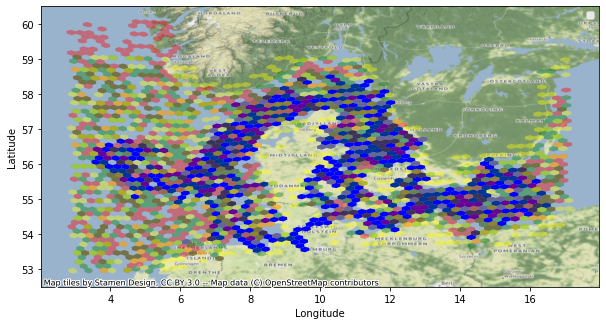

In [41]:
plt = a_sample.plot(figsize=(10,12),color="blue")
w_sample.plot(ax=plt, color="red", alpha=0.4)
c_sample.plot(ax=plt, color="green", alpha=0.4)
wi_sample.plot(ax=plt, color="yellow", alpha=0.4)
plt.set_ylabel('Latitude')
plt.set_xlabel('Longitude')
plt.set_label('Label via method')

plt.legend()
ctx.add_basemap(plt, crs=4326)

In [208]:
ais_enhanced = (ais
                .pipe(merge_ais_with_weather, wave)
                .pipe(merge_ais_with_weather, wind)
                .pipe(merge_ais_with_weather, current))

In [209]:
joblib.dump(ais_enhanced, data / "cargo_tanker_wetter.joblib")

['data\\cargo_tanker_wetter.joblib']